* **Members Name**: Alex Cohen, Gabriel Scholze, Matheus Muller, Yerik K.

In [ ]:
#To ensure a unique execution and reproducibility, define a seed number as follows:
seed_number = 915_632

#Data Preparation
*   Download
*   Unzip





In [ ]:
import numpy as np
import cv2, math, os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import skimage.feature as feature
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

In [ ]:
!wget www.ppgia.pucpr.br/~aghochuli/paper-rock-scissors.zip -O paper-rock-scissors.zip
!unzip -qo paper-rock-scissors.zip

--2023-10-09 18:42:56--  http://www.ppgia.pucpr.br/~aghochuli/paper-rock-scissors.zip
Resolving www.ppgia.pucpr.br (www.ppgia.pucpr.br)... 104.18.10.132, 104.18.11.132, 2606:4700::6812:a84, ...
Connecting to www.ppgia.pucpr.br (www.ppgia.pucpr.br)|104.18.10.132|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.ppgia.pucpr.br/~aghochuli/paper-rock-scissors.zip [following]
--2023-10-09 18:42:56--  https://www.ppgia.pucpr.br/~aghochuli/paper-rock-scissors.zip
Connecting to www.ppgia.pucpr.br (www.ppgia.pucpr.br)|104.18.10.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 159581239 (152M) [application/zip]
Saving to: ‘paper-rock-scissors.zip’

paper-rock-scissors 100%[===================>] 152.19M   184MB/s    in 0.8s    

2023-10-09 18:42:57 (184 MB/s) - ‘paper-rock-scissors.zip’ saved [159581239/159581239]



### Auxiliary Functions
  * Plot Image Side by Side
  * Load Dataset

In [ ]:
#Auxiliary Function to plot side by side
def plot_sidebyside(img_list,titles=None,colormap=None,figsize=(12,6)):
  n = len(img_list)
  figure, axis = plt.subplots(1, n, figsize=figsize)

  if titles is None:
    titles = []
    A = ord('A')
    for i in range(n):
      titles.append(chr(A+i))

  for i in range(n):
    axis[i].imshow(img_list[i], cmap=colormap)
    axis[i].set_title(titles[i])
    axis[i].axis('off')
  # Combine all the operations and display
  plt.show()

In [ ]:
def load_dataset(data_folder):

    images = []
    labels = []
    labels_names = {}
    class_folders = os.listdir(data_folder)

    for index,class_folder in enumerate(class_folders):
        labels_names[str(index)] = class_folder
        class_path = os.path.join(data_folder, class_folder)

        if os.path.isdir(class_path):
            label = class_folder
            image_files = os.listdir(class_path)

            for image_file in image_files:
                image_path = os.path.join(class_path, image_file)

                # Carregua a imagem usando o OpenCV
                image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
                if image is not None:
                    #Redimensiona para 96x96 para diminuir a resolucao
                    image = cv2.resize(image,(96,96),interpolation = cv2.INTER_NEAREST)
                    images.append(image)
                    labels.append(index)

    # Converta as listas de imagens e labels em vetores numpy
    images = np.array(images)
    labels = np.array(labels)

    x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=seed_number)

    return x_train, x_test, y_train, y_test, labels_names




(1750, 96, 96, 3) (438, 96, 96, 3) (1750,) (438,)
{'0': 'rock', '1': 'paper', '2': 'scissors'}


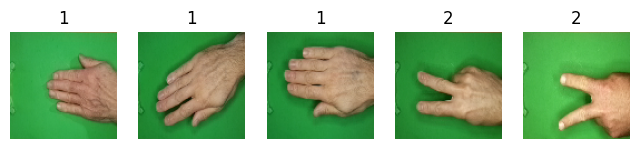

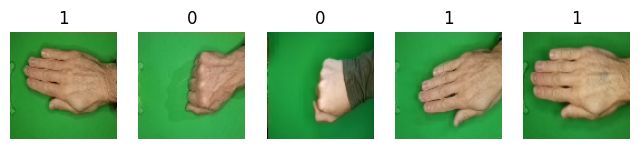

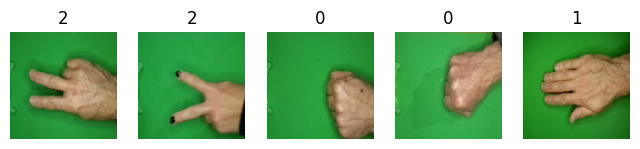

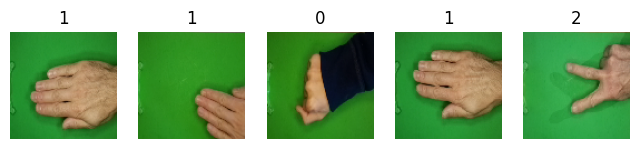

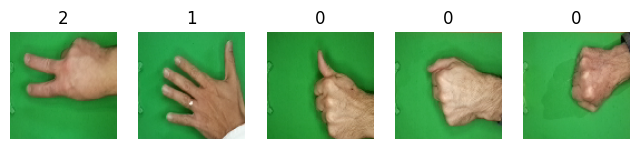

In [ ]:
path = './paper-rock-scissors'
x_train, x_test, y_train, y_test, lbl_names = load_dataset(path)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

print(lbl_names)
for i in range(5):
  plot_sidebyside(x_train[i*5:i*5+5],y_train[i*5:i*5+5],figsize=(8,4))

### Segmentation Step (4 points)
  Below, you are invited to develop your strategy for hand segmentation. Go back to the first classes, and try some techniques to:
*   Enhance the image (filtering, light normalization, morphology, color space)
*   Binarization
*   Connected Components

The expected output of this step is a list of images containing only the crop of hand gestures.

Alternating code and text cells, you should demonstrate a strong understanding of the techniques used, how they were applied, and why specific choices were made. Use evidence from the results, visualizations, and metrics to persuade the professor of your comprehension and proficiency in the classification process.

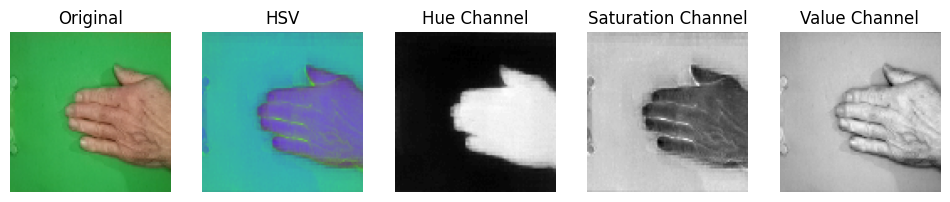

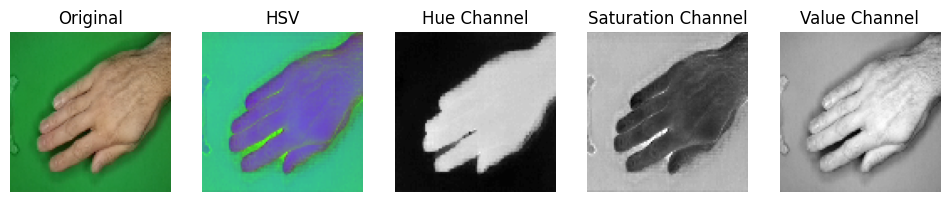

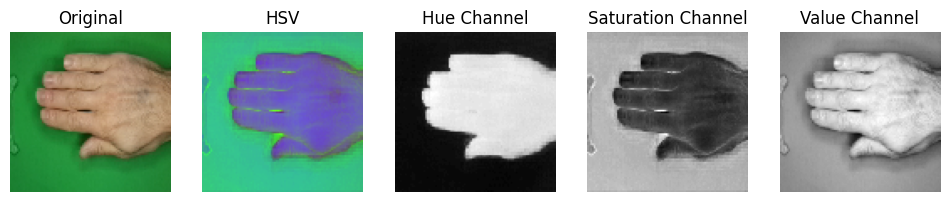

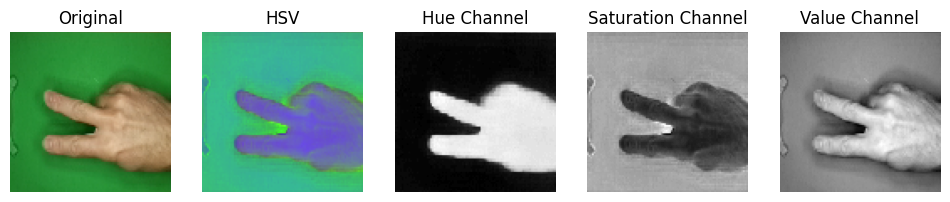

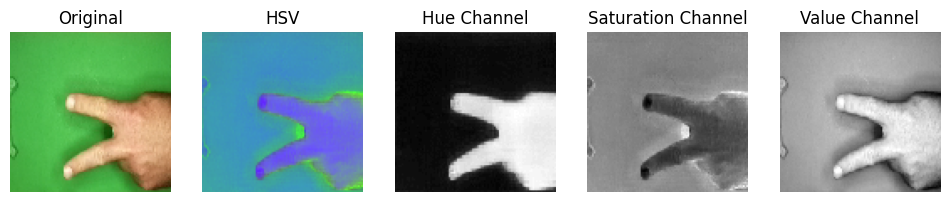

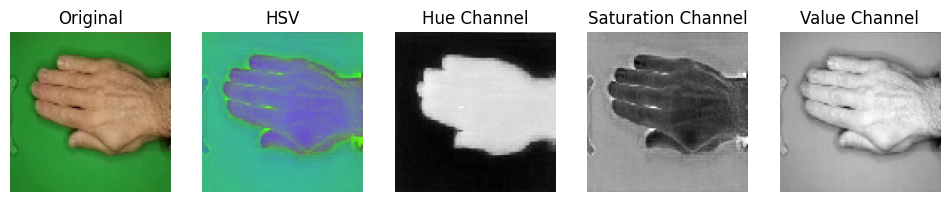

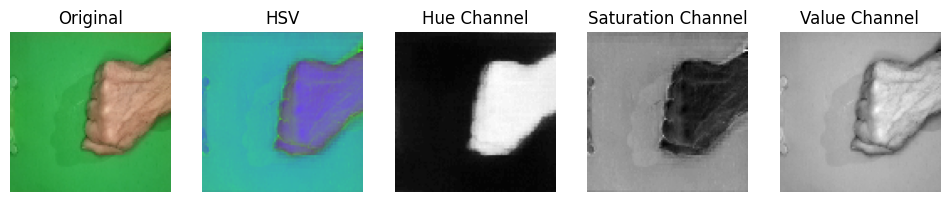

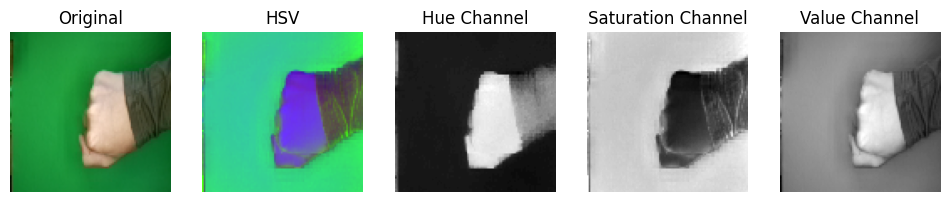

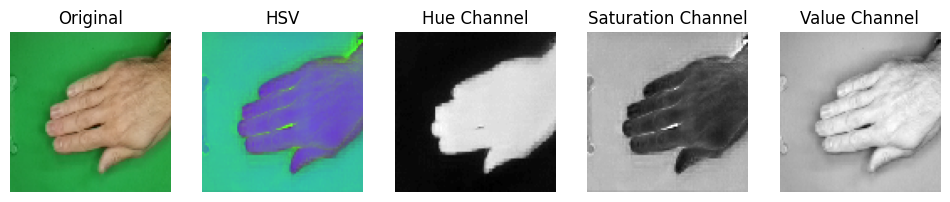

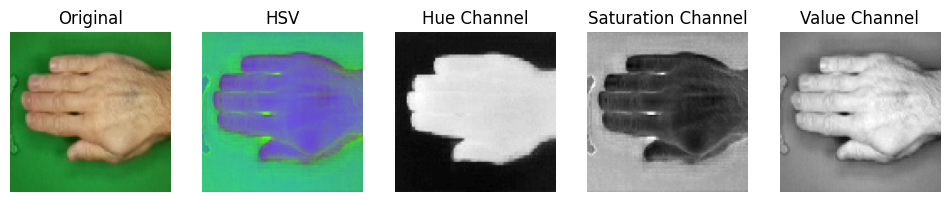

In [ ]:
for idx, img in enumerate(x_train[:10]):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    H = hsv[:,:,0]
    S = hsv[:,:,1]
    V = hsv[:,:,2]
    plot_sidebyside([img,hsv, H, S, V], ["Original","HSV", "Hue Channel","Saturation Channel","Value Channel"], colormap='gray', figsize=(12,6))

# plot 10 imagens do canal HSV
# Usamos o Hue Channel porque apresentou a maior diferença entre o fundo e a mão

Analizando as imagens, percebemos uma grande diferença entre o fundo e o objeto. Mais especificamente o fundo tem coloração verde, portanto imaginamos que o canal HUE (a cor no espectro de cores visiveis) teria melhor performance

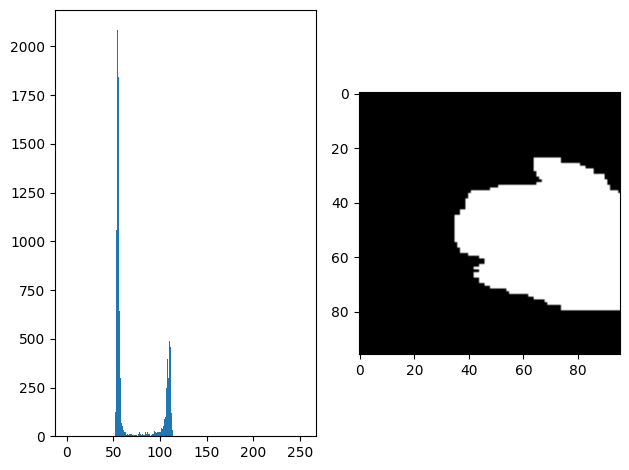

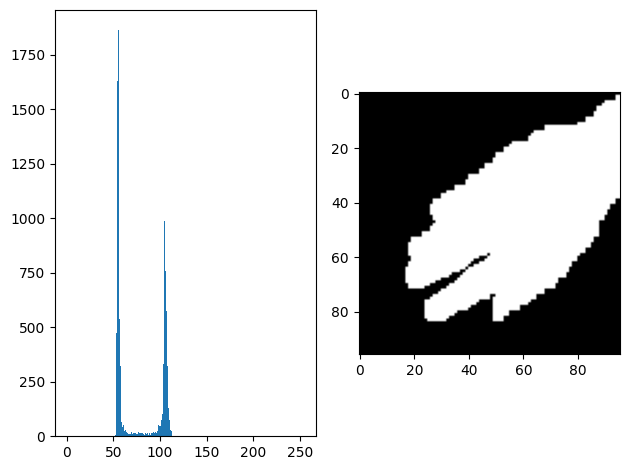

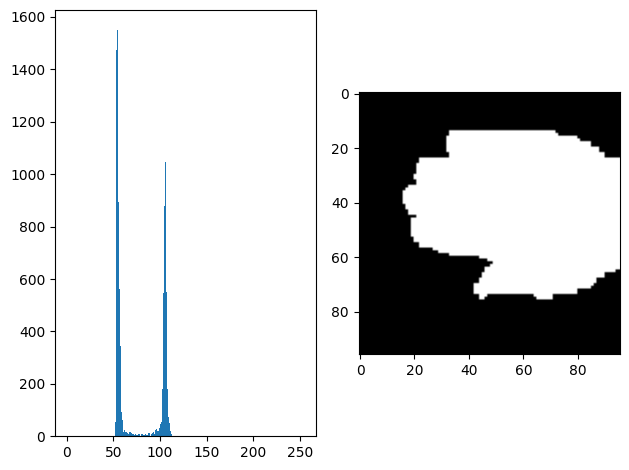

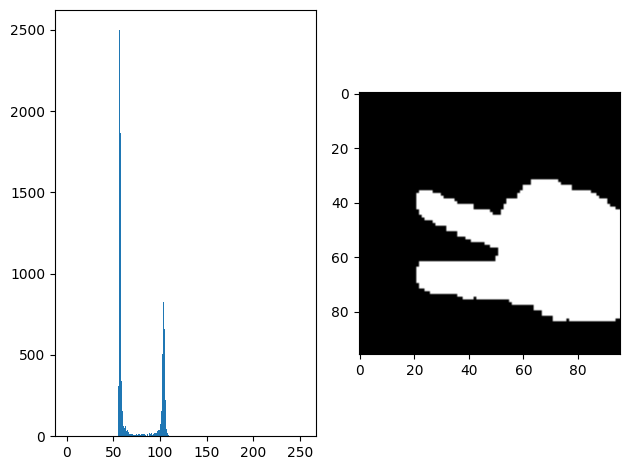

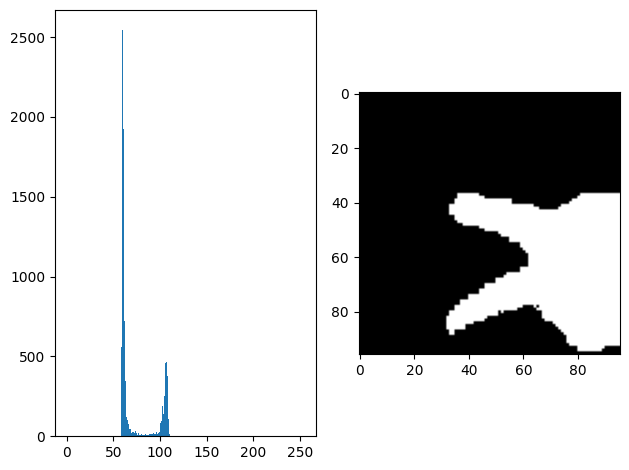

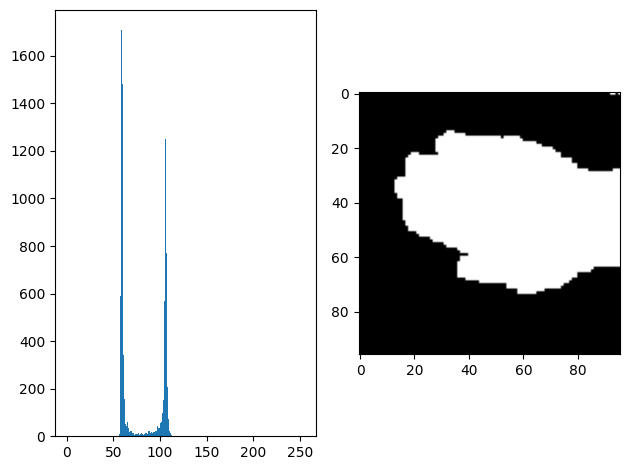

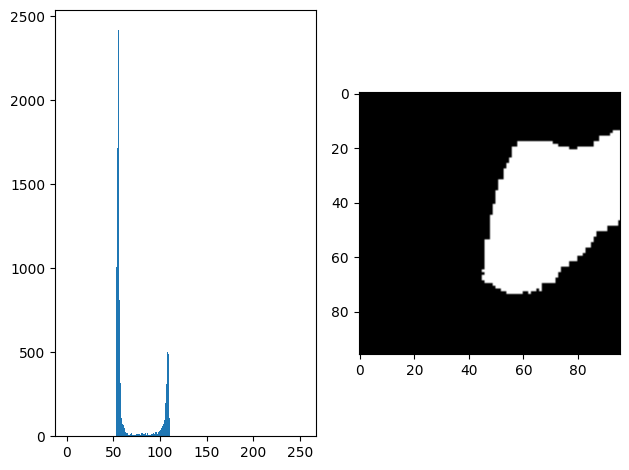

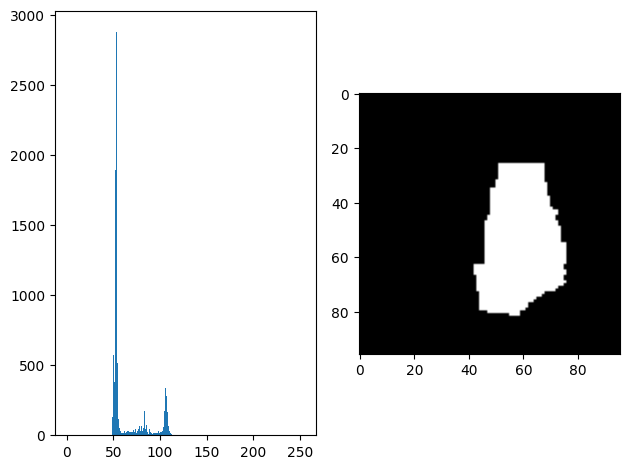

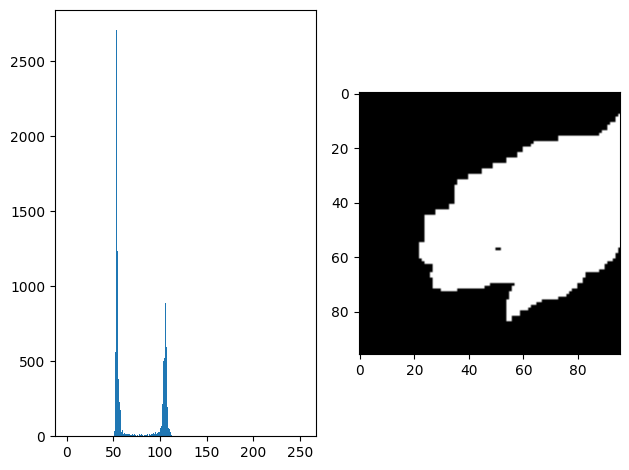

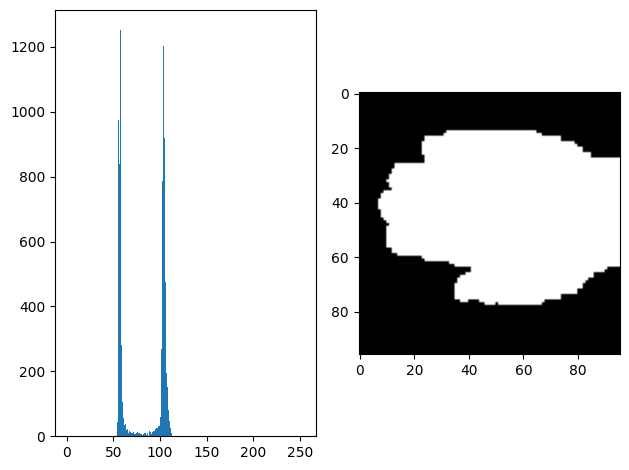

In [ ]:
binarized_images = []
for idx, img in enumerate(x_train[:10]):

    fig, (ax1, ax2) = plt.subplots(1,2)

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    S = hsv[:,:,0]
    ax1.hist(S.ravel(), 256, [0,255]);

    val = 90
    _, thresh = cv2.threshold(S, val, 256, cv2.THRESH_BINARY)
    ax2.imshow(thresh,cmap='gray')
    plt.tight_layout()
    plt.show()
    binarized_images.append(thresh)

# Primeiro plotamos o histograma do HUE para posteriormente binarizar as imagens usando threshold
# val = 90, tudo abaixo fica preto e acima fica branco

Inicialmente, pegamos a imagem e plotamos um histograma do HUE. Existe uma grande diferença entre a cor do fundo e da mão esperavamos encontrar dois picos no histograma. Ao plotar os valores, notamos que os picos se concentravam por volta de 50 para o fundo e 100 para a mão. Decidimos fazer binarização utilizando o Threshold de 90 para selecionar apenas a mão.



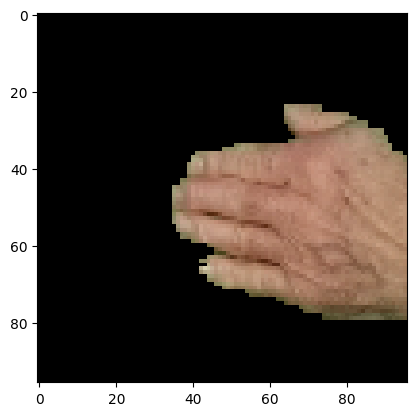

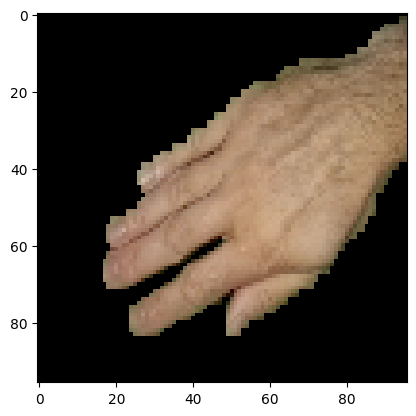

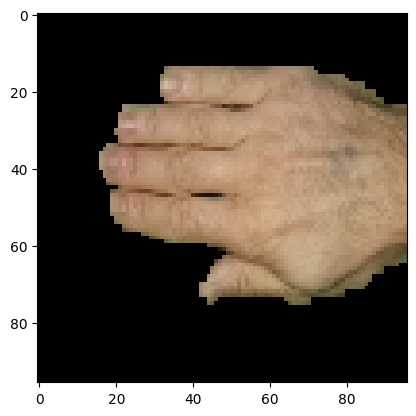

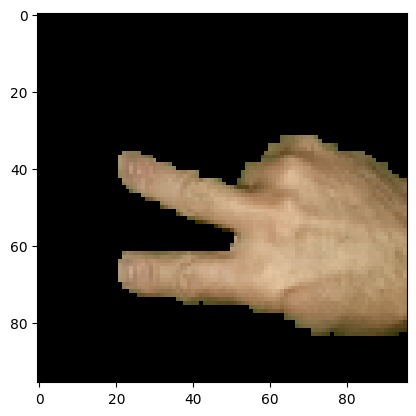

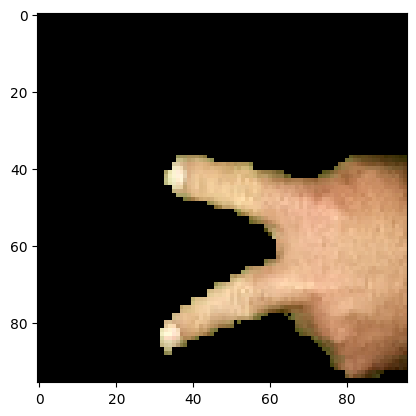

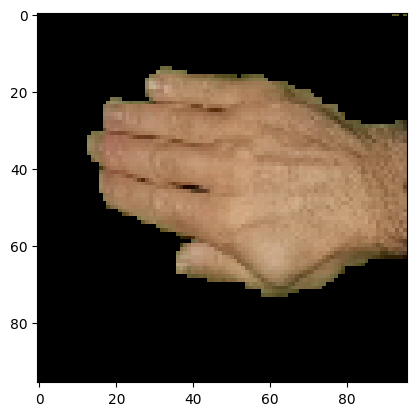

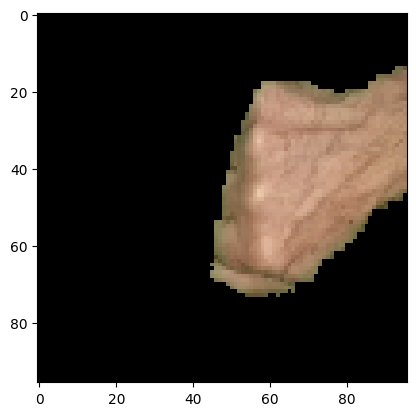

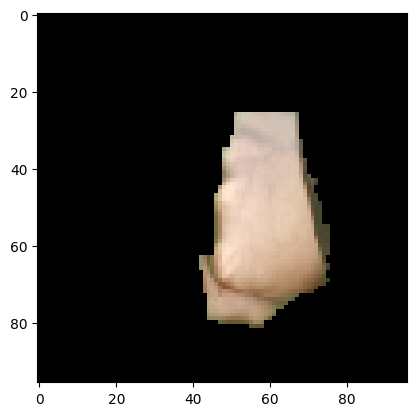

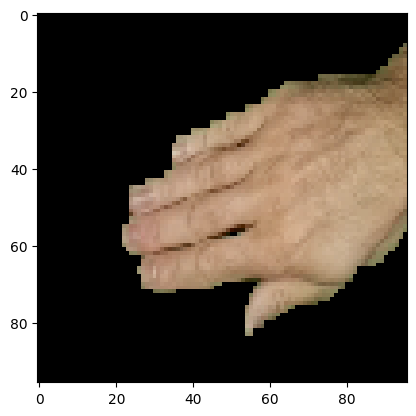

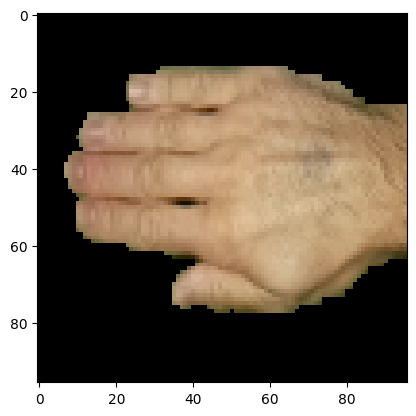

In [ ]:
for hand_pre, hand_mask in zip(x_train[:10], binarized_images):
    result = cv2.bitwise_and(hand_pre, hand_pre, mask= hand_mask)
    plt.imshow(result, cmap='gray')
    plt.show()

Demonstração dos resultados obtidos (mascaras encontradas)

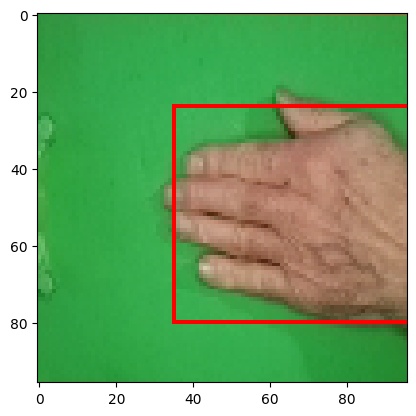

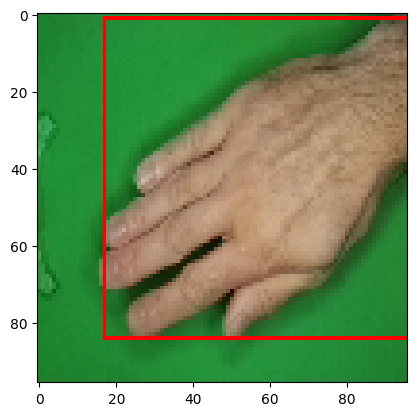

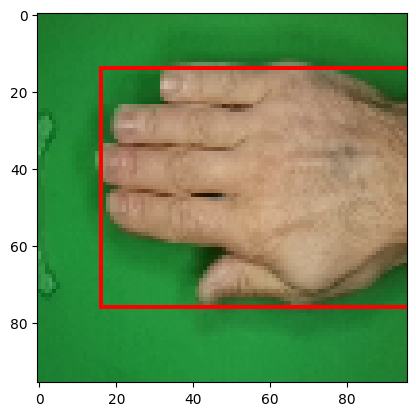

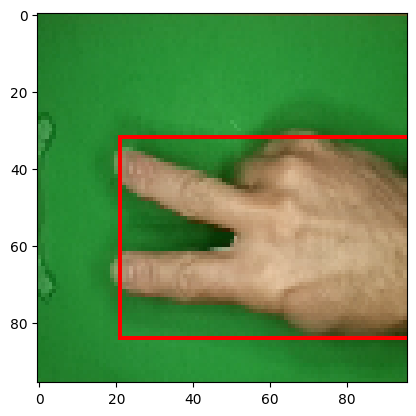

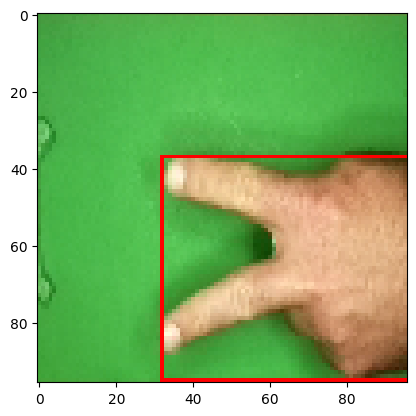

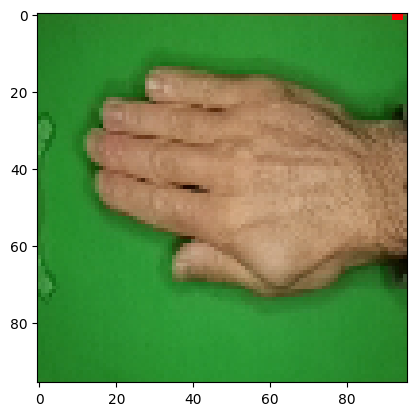

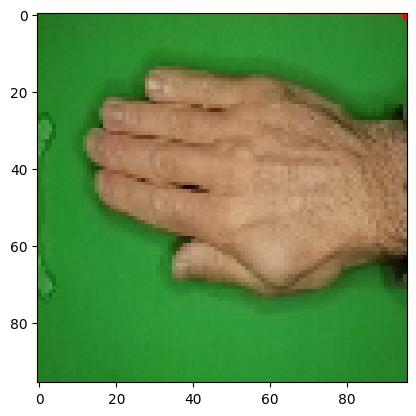

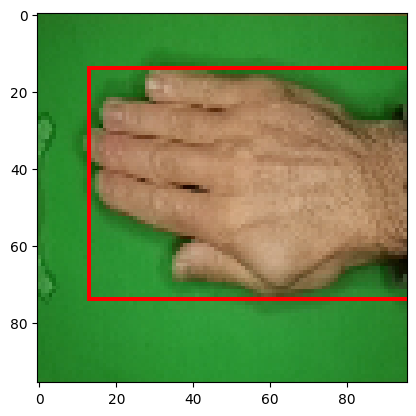

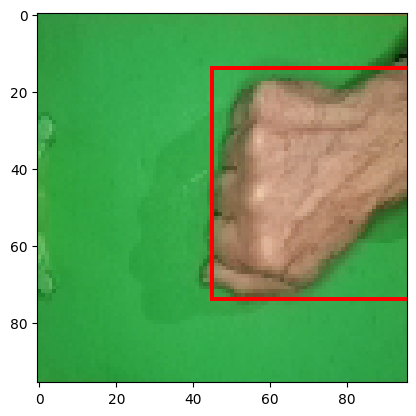

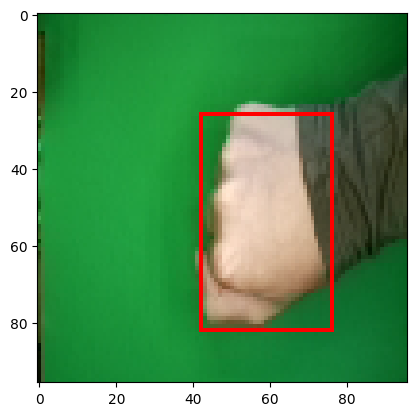

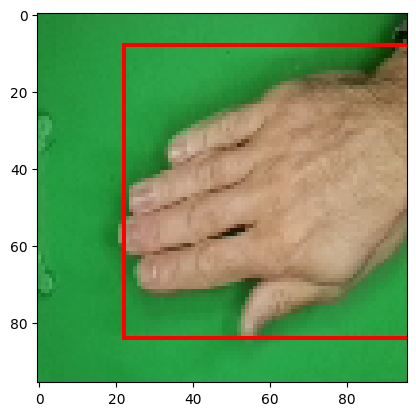

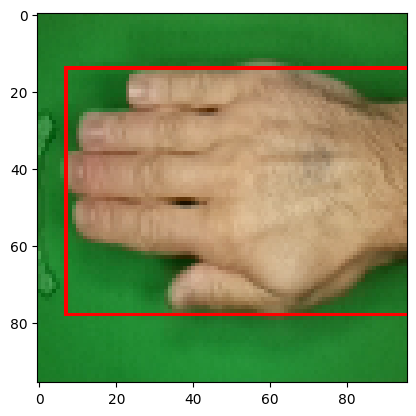

In [ ]:
components_full = []
components_mask = []
for hand_pre, hand_mask in zip(x_train[:10], binarized_images):
    connectivity = 8  # You need to choose 4 or 8 for connectivity type
    num_labels, cc_image, stats, centroids = cv2.connectedComponentsWithStats(hand_mask , connectivity , cv2.CV_32S)
    for i in range(1,num_labels):
        temp = hand_pre.copy()

        x,y,w,h = stats[i][:4]

        area = stats[i][4]
        cx,cy = centroids[i]
        component = hand_pre[y:y+h, x:x+w]
        components_full.append(hand_pre[y:y+h, x:x+w])
        components_mask.append(hand_mask[y:y+h, x:x+w])
        markup = cv2.rectangle(temp,(x,y),(x+w,y+h),(255,0,0),thickness=1)
        plt.imshow(temp,cmap='gray')
        plt.show()

Demonstração dos componentes encontrados utilizando `connectedComponentsWithStats` para detectar grupos de pixels conectados

### **Final Remarks (Segmentation Step)**:
  Discuss in-depth the results achieve in this step.
* Is there any bottleneck?

Sim. As classes "Papel" e "Pedra" são muito similares, o que dificulta a segmentação das duas e, futuramente, afetará a acurácia dos modelos.
* What technique worked better? or what did not work?

Ao analisar o HSV, devido a diferença de cores entre o fundo e mão de cada imagem, o canal HUE provou ser o mais adequado para trabalhar.
* What motivated you to implement that approach?

Analisando o histograma, vimos que a diferença de cores entre o fundo e mão é suficiente para identificar cada mão de maneira precisa.
* Plot a few sample to elucidate the final result








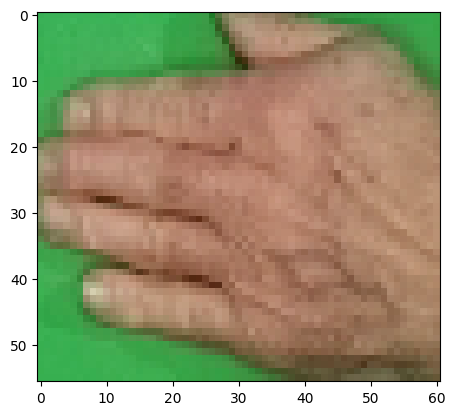

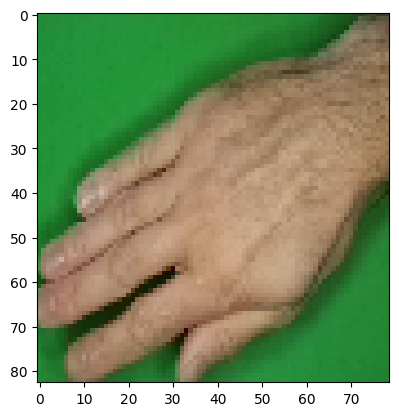

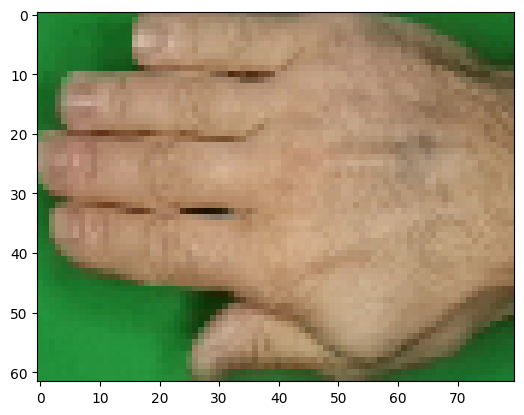

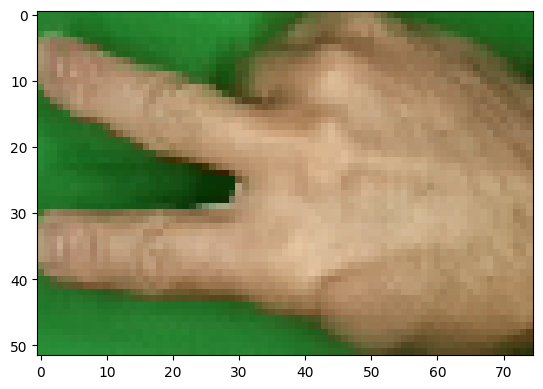

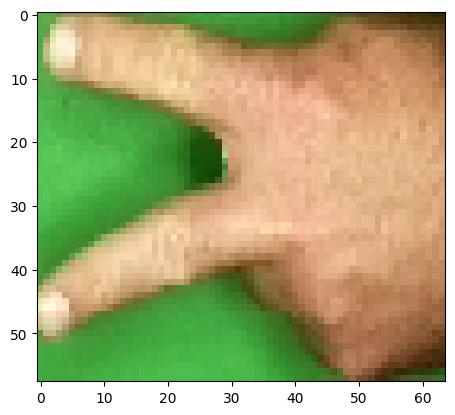

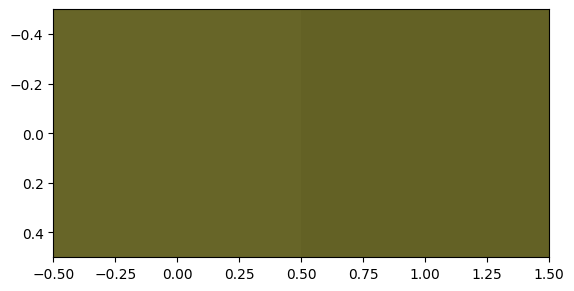

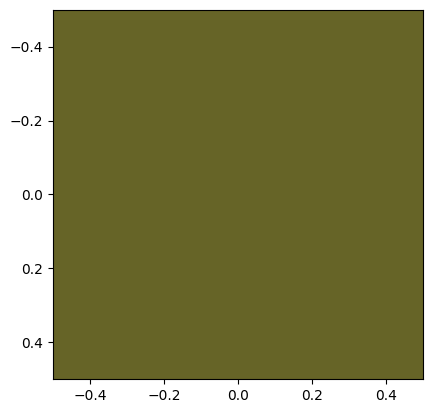

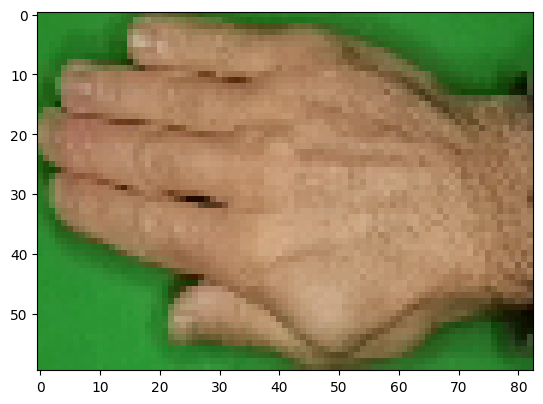

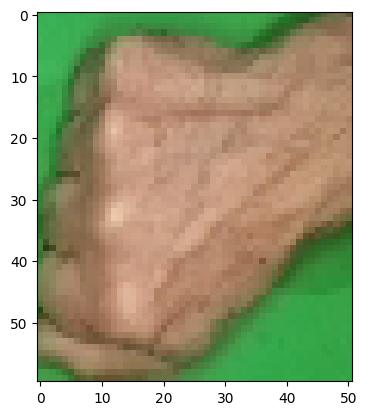

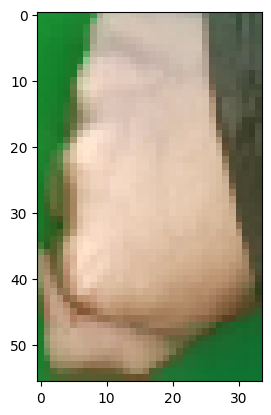

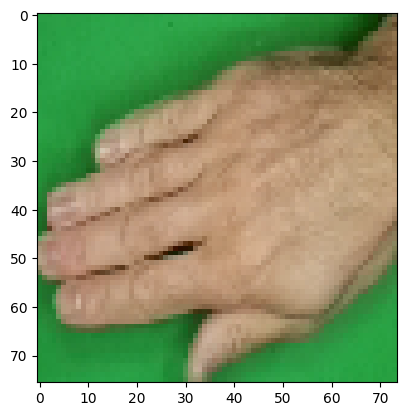

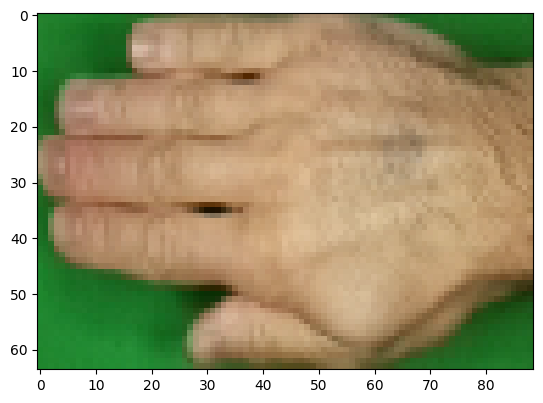

In [ ]:
for img in components_full:
  plt.imshow(img)
  plt.show()

## Classification Step (6 points)

Here, you are expected to apply several image descriptors and evaluate several classification models. An in-depth discussion concerning the foundation and logic behind the techniques is mandatory.

You can use a visualization tool (TSNE or PCA) to provide a better understanding of feature space.

Based on that, you can compare different descriptors fairly. And then discuss the better pipeline (features and models) that achieved the better performance.

The expected output of this step is a comparison of several models, elucidating the best one, and a critical analysis based on the classification report and confusion matrix.

Demonstrate a strong understanding of the techniques used, how they were applied, and why specific choices were made. Use evidence from the results, visualizations, and metrics to persuade the professor of your comprehension and proficiency in the classification process.


Para a primeira implementação de descritores de imagens, decidimos usar o HOG.
Como o Hog gera features proximas ao contorno, acreditamos que teria uma boa performance considerando como o perfil da mão difere entre as poses que são classificadas

In [ ]:
def describe_hog(im,pixels_per_cell=(8, 8),cells_per_block=(2, 2),img_size=(192,192)):
    if len(im.shape) > 2 and im.shape[2] == 3:
      im = cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)

    im = cv2.resize(im,img_size)

    fd, hog_image = feature.hog(im, orientations=9, pixels_per_cell=pixels_per_cell,
                	cells_per_block=cells_per_block,visualize=True)
    return fd,hog_image

Acima temos uma implementação da geração de um vetor de features utilizando HOG. Para a geração do hog decidimos aumentar a resolução da imagem de entrada para 384x192 para ter contornos mais detalhados. Um exemplo de como aumentar a imagem gera melhores contornos:



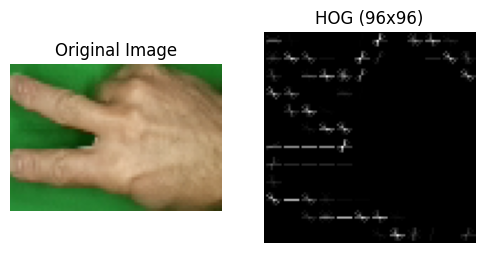

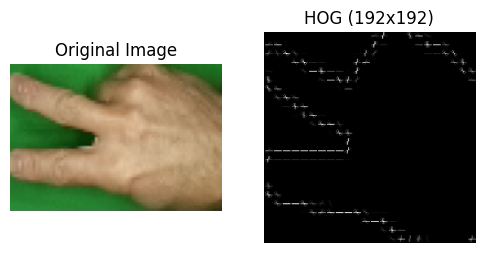

In [ ]:
mask = components_mask[3]
og = components_full[3]
_, hog_img = describe_hog(mask,img_size=(96,96))
plot_sidebyside([og,hog_img],
                ['Original Image','HOG (96x96)'],
                colormap='gray',
                figsize=(6,4))
_, hog_img = describe_hog(mask)
plot_sidebyside([og,hog_img],
                ['Original Image','HOG (192x192)'],
                colormap='gray',
                figsize=(6,4))

Apesar de não ter mais dados, a resolução maior gerou melhores contornos ao redor dos dedos. o Hog originalmente foi desenvolvido para a detecção de pessoas, por conta disso o aspect ratio utilizado era de 1:2 (A altura era 2x maior que a largura da imagem), entretando como nas fotos as mãos tem comprimento maior na horizontal, decidimos inverter o aspect ratio para 2:1, respeitando os valores possíveis de resolução

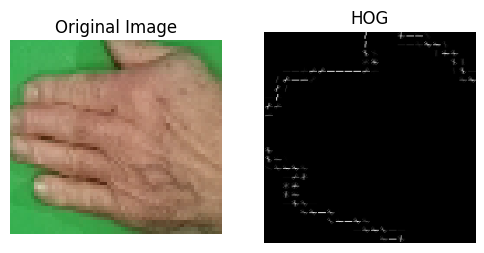

[0. 0. 0. ... 0. 0. 0.] (19044,) (56, 61, 3)


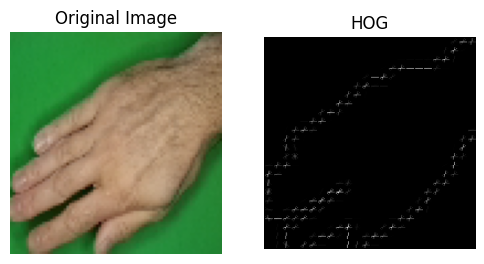

[0. 0. 0. ... 0. 0. 0.] (19044,) (83, 79, 3)


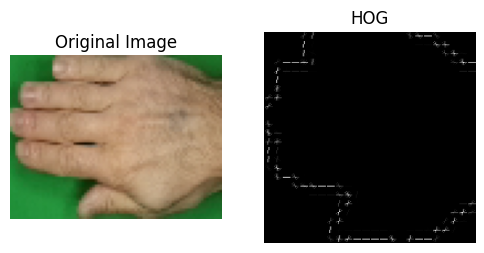

[0. 0. 0. ... 0. 0. 0.] (19044,) (62, 80, 3)


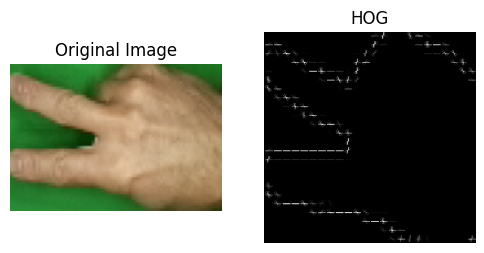

[0. 0. 0. ... 0. 0. 0.] (19044,) (52, 75, 3)


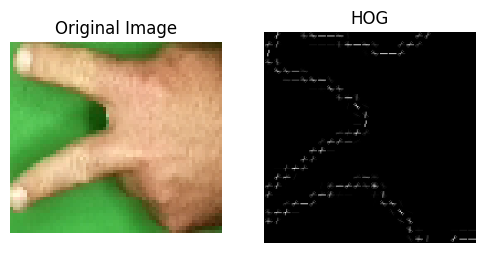

[0.05517248 0.         0.         ... 0.         0.         0.        ] (19044,) (58, 64, 3)


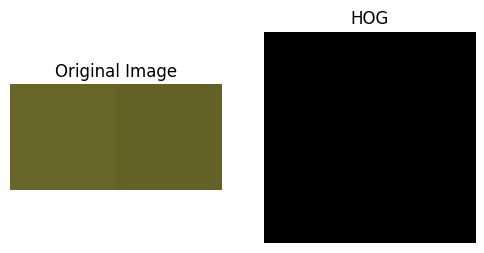

[0. 0. 0. ... 0. 0. 0.] (19044,) (1, 2, 3)


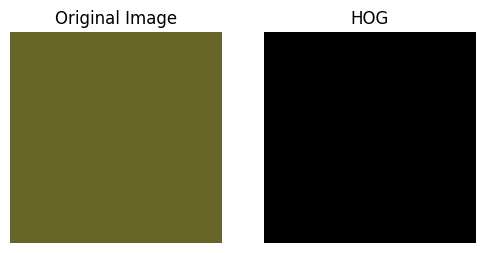

[0. 0. 0. ... 0. 0. 0.] (19044,) (1, 1, 3)


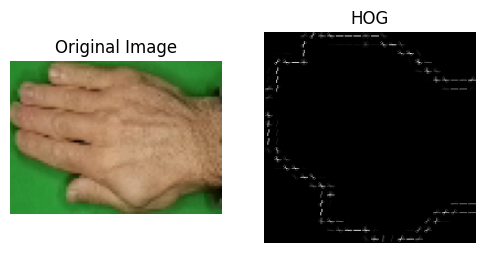

[0. 0. 0. ... 0. 0. 0.] (19044,) (60, 83, 3)


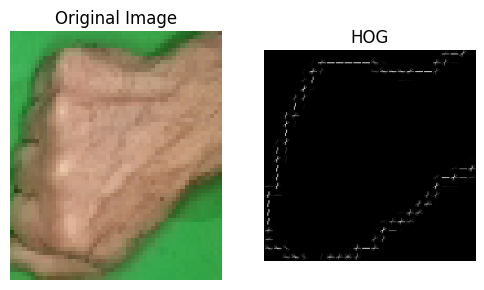

[0. 0. 0. ... 0. 0. 0.] (19044,) (60, 51, 3)


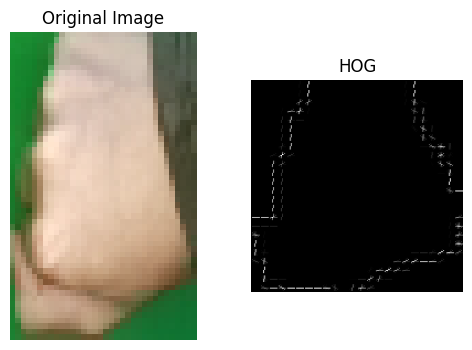

[0. 0. 0. ... 0. 0. 0.] (19044,) (56, 34, 3)


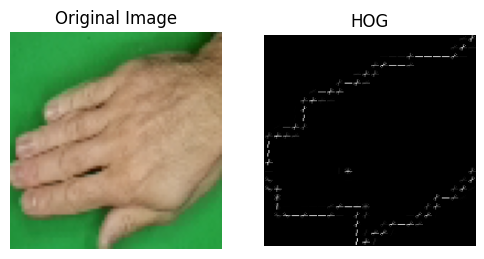

[0. 0. 0. ... 0. 0. 0.] (19044,) (76, 74, 3)


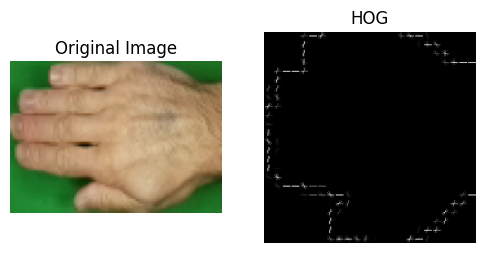

[0. 0. 0. ... 0. 0. 0.] (19044,) (64, 89, 3)


In [ ]:
for hand_pre, hand_mask in zip(components_full, components_mask):
    key_pts, hog_img = describe_hog(hand_mask)
    plot_sidebyside([hand_pre,hog_img],
                ['Original Image','HOG'],
                colormap='gray',
                figsize=(6,4))
    print(key_pts,key_pts.shape,hand_pre.shape)

Acima a demonstração da geração do Hog para algumas imagens da Base.



O segundo método de extração de features escolhido foi huMoments. Esse método também é fortemente baseado no contorno (shape) do objeto

In [ ]:
def describe_hu(im,threshold=90):

    if len(im.shape) > 2 and im.shape[2] == 3:
      im = cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)


    _,threshold = cv2.threshold(im, threshold, 255, cv2.THRESH_BINARY)

    # Calculate Moments
    moments = cv2.moments(im)
    # Calculate Hu Moments
    huMoments = cv2.HuMoments(moments)

    # Log scale hu moments
    for i in range(0,len(huMoments)):
      if huMoments[i] != 0:
        huMoments[i] = -1* math.copysign(1.0, huMoments[i]) * math.log10(abs(huMoments[i]))

    #There is resulting image for HuMoments
    return huMoments.reshape(huMoments.shape[0]), threshold

In [ ]:
for hand_pre, hand_mask in zip(components_full, components_mask):
    huMoments, threshold = describe_hu(hand_mask)
    print(huMoments)


[ 3.17543393  7.83646432 10.45667625 12.77408019 25.17251449 18.28569398
 24.39543711]
[ 3.09901627  6.67782149 10.8047969  11.95567689 23.71515102 15.84445116
 23.37752673]
[ 3.17561657  7.45190583 11.13206221 12.49281878 24.51773561 16.34260299
 24.40762466]
[  3.09133953   6.94809318  10.3524364   10.68278025  21.20234139
  14.16598252 -22.22441116]
[ 3.06265434  7.79181858 10.74847592 10.55248447 21.22490225 14.70318652
 21.71162385]
[3.30963017 6.61926033 0.         0.         0.         0.
 0.        ]
[0. 0. 0. 0. 0. 0. 0.]
[  3.15280838   7.04219837  11.38592293  12.82499039  25.48073156
  17.40080423 -24.94839477]
[  3.1435325    7.02787017  10.71656267  12.55576017 -24.54411375
 -16.46308588  24.23970505]
[ 3.10447659  6.72804156 10.30548468 11.44377316 22.60860094 15.30135721
 22.3846053 ]
[  3.15093375   7.14047655  10.57947435  12.26124916 -23.68190334
 -15.83289999 -25.11712485]
[ 3.17064987  7.29873488 11.37457796 12.63418643 24.66271835 16.28473761
 25.12745272]


O ultimo método de extração de features escolhido foi Gabor. Esse método realça bastante os contornos da imagem e acreditamos que as features poderiam ser determinantes para o modelo

In [ ]:
class GABOR:
    def __init__(self,ksize=31,n_filters=8):
        self.filters = []

        for theta in np.arange(0, np.pi, np.pi / n_filters):
            kern = cv2.getGaborKernel((ksize, ksize), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
            kern /= 1.5*kern.sum()
            self.filters.append(kern)

    def get_filters(self):
      return self.filters

    def describe(self,im):
        if len(im.shape) > 2 and im.shape[2] == 3:
          im = cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)

        gabor_img = np.zeros_like(im)
        for kern in self.filters:
            f_im = cv2.filter2D(im, cv2.CV_8UC3, kern)
            np.maximum(gabor_img, f_im, gabor_img)

        return gabor_img.reshape(-1), gabor_img

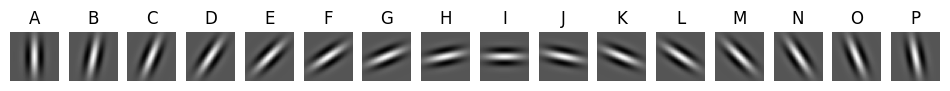

(56, 61)


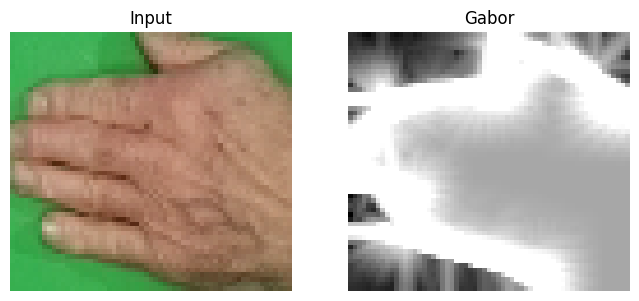

[ 54  50  40 ... 170 170 170]
(83, 79)


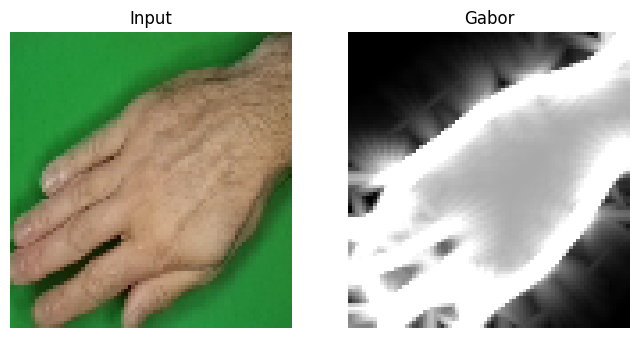

[0 0 0 ... 0 0 0]
(62, 80)


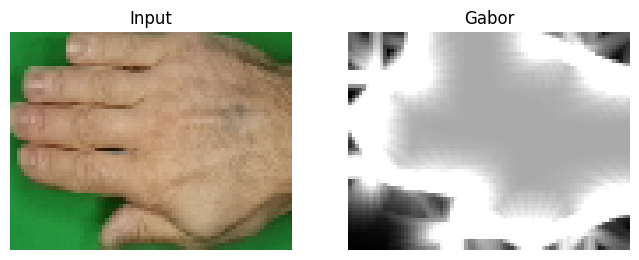

[103  97  82 ...  86  90  91]
(52, 75)


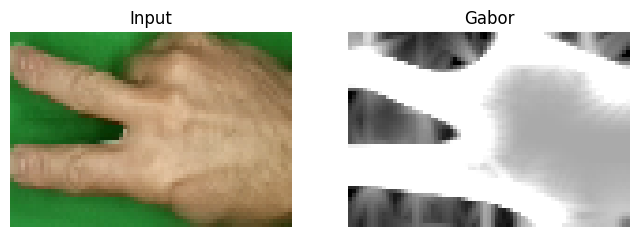

[164 161 154 ... 153 127 117]
(58, 64)


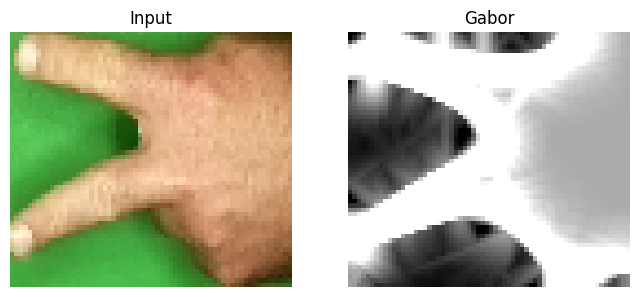

[  0   0  34 ...  95 123 135]
(1, 2)


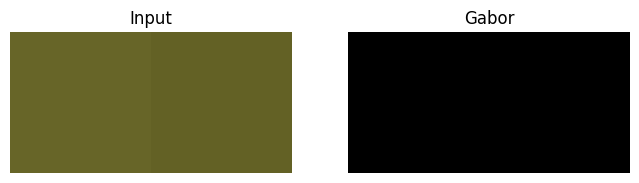

[170 170]
(1, 1)


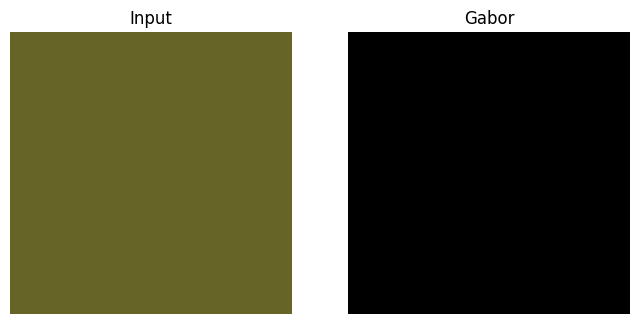

[170]
(60, 83)


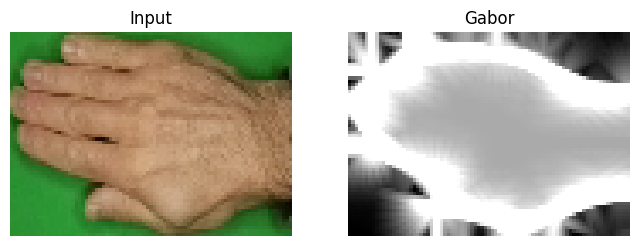

[183 172 140 ...  56  61  61]
(60, 51)


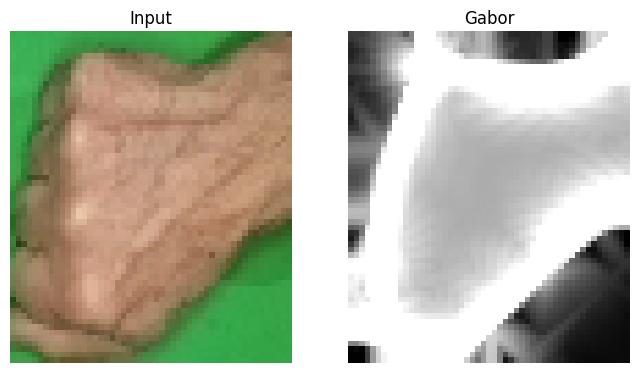

[59 60 61 ... 11 11 10]
(56, 34)


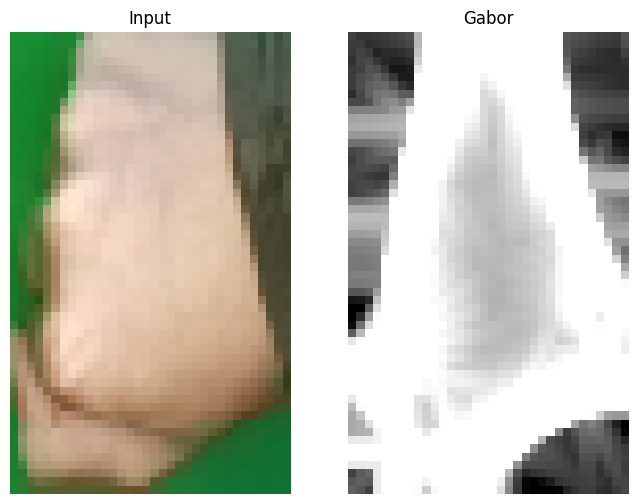

[62 52 53 ... 43 58 71]
(76, 74)


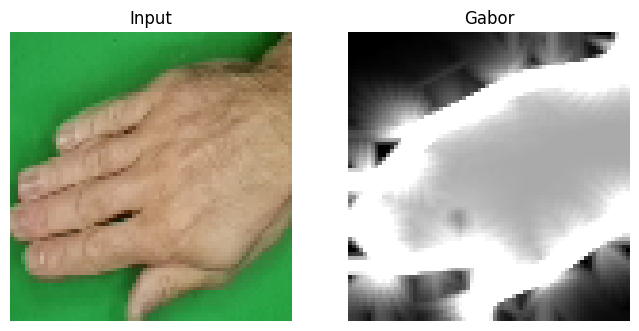

[ 0  0  0 ... 10 10  9]
(64, 89)


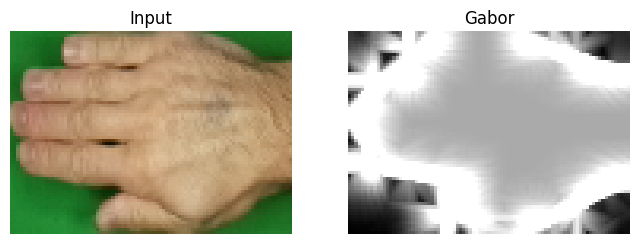

[54 51 42 ...  9 12 13]


In [ ]:
gabor = GABOR(32,16)
filters = gabor.get_filters()
filters = np.array(filters)

plot_sidebyside(filters,colormap='gray')
for img, mask in zip(components_full, components_mask):

  features,gabor_img = gabor.describe(mask)
  print(gabor_img.shape)
  plot_sidebyside([img,gabor_img],
                ['Input','Gabor'],
                colormap='gray',
                figsize=(8,6))
  print(features)

Demonstração da aplicação de Gabor para a extração de features

In [ ]:
segmented_train = []
original_train = []
labels_train = []

for idx, (img, label) in enumerate(zip(x_train, y_train)):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    S = hsv[:,:,0]

    val = 90
    _, hand_mask = cv2.threshold(S, val, 256, cv2.THRESH_BINARY)

    connectivity = 8  # You need to choose 4 or 8 for connectivity type
    num_labels, cc_image, stats, centroids = cv2.connectedComponentsWithStats(hand_mask , connectivity , cv2.CV_32S)
    if num_labels < 2:
        continue

    x,y,w,h = stats[i][:4]
    component = hand_mask[y:y+h, x:x+w]

    segmented_train.append(component)
    original_train.append(img)
    labels_train.append(label)

In [ ]:
segmented_test = []
original_test = []
labels_test = []

for idx, (img, label) in enumerate(zip(x_test, y_test)):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    S = hsv[:,:,0]

    val = 90
    _, hand_mask = cv2.threshold(S, val, 256, cv2.THRESH_BINARY)

    connectivity = 8  # You need to choose 4 or 8 for connectivity type
    num_labels, cc_image, stats, centroids = cv2.connectedComponentsWithStats(hand_mask , connectivity , cv2.CV_32S)
    if num_labels < 2:
        continue

    x,y,w,h = stats[i][:4]
    component = hand_mask[y:y+h, x:x+w]

    segmented_test.append(component)
    original_test.append(img)
    labels_test.append(label)

O código acima faz a segmentação de todas as imagens de treino e teste

In [ ]:
instances_hog_train = []
for img in segmented_train:
    key_pts, _ = describe_hog(img)
    instances_hog_train.append(key_pts)

In [ ]:
instances_hog_test = []
for img in segmented_test:
    key_pts, _ = describe_hog(img)
    instances_hog_test.append(key_pts)

In [ ]:
instances_hu_train = []
for img in segmented_train:
    key_pts, _ = describe_hu(img)
    instances_hu_train.append(key_pts)

In [ ]:
instances_hu_test = []
for img in segmented_test:
    key_pts, _ = describe_hu(img)
    instances_hu_test.append(key_pts)

In [ ]:
instances_gabor_train = []
for img in segmented_train:
    key_pts, _ = gabor.describe(mask)
    instances_gabor_train.append(key_pts)

In [ ]:
instances_gabor_test = []
for img in segmented_test:
    key_pts, _ = gabor.describe(mask)
    instances_gabor_test.append(key_pts)

Nesta etapa é realizada a extração de features utilizando os métodos apresentados anteriormente: Hog, huMoments e Gabor




In [ ]:
lbls_name = ["Pedra", "Tesoura", "Papel"]
def performance_evaluation(y_test, predictions,info_message,figsize=(18, 4)):

  print(f"Evaluation of ", info_message)
  print(f"{metrics.classification_report(y_test, predictions)}\n")
  print(lbls_name)
  disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictions)
  disp.figure_.suptitle("Confusion Matrix")
  plt.show()
  print('\n')
  id = np.random.randint(300)
  idx1,idx2=id,id+20
  diff = np.absolute(y_test.astype(np.int32) - predictions)
  idxs = np.where(diff == 0)

  _, axes = plt.subplots(nrows=1, ncols=(idx2-idx1), figsize=figsize)
  for ax, image, lbl, prediction, in zip(axes, x_test[idxs],y_test[idxs], predictions[idxs]):
      ax.set_axis_off()
      ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
      ax.set_title(f'Label: {lbl}')
      ax.text(0.5, 0.0, f'Pred: {prediction}', ha='center', va='center', transform=ax.transAxes)

  idxs = np.where(diff != 0)
  plt.show()

  print('\n')
  _, axes = plt.subplots(nrows=1, ncols=(idx2-idx1), figsize=figsize)
  for ax, image, lbl, prediction, in zip(axes, x_test[idxs],y_test[idxs], predictions[idxs]):
      ax.set_axis_off()
      ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
      ax.set_title(f'Label: {lbl}')
      ax.text(0.5, 0.0, f'Pred: {prediction}', ha='center', va='center', transform=ax.transAxes)
  plt.show()
  print('\n')

Implementação das métricas de avaliação para um modelo, com a matriz de confusão e os scores em precisão, recall, F1 Score



#### MLP - Hog

Utilização do MLP Multi-layer Perceptron para treinamento e validação utilizando Hog. Esse modelo apresentou o melhor F1 com 92% de acurácia

In [ ]:
max_iter = 100
clf = MLPClassifier(max_iter=max_iter)
clf.fit(instances_hog_train,labels_train)

MLPClassifier(max_iter=100)

Evaluation of  MLP
              precision    recall  f1-score   support

           0       0.85      0.97      0.91       147
           1       0.98      0.86      0.91       149
           2       0.96      0.93      0.94       142

    accuracy                           0.92       438
   macro avg       0.93      0.92      0.92       438
weighted avg       0.93      0.92      0.92       438


['Pedra', 'Tesoura', 'Papel']


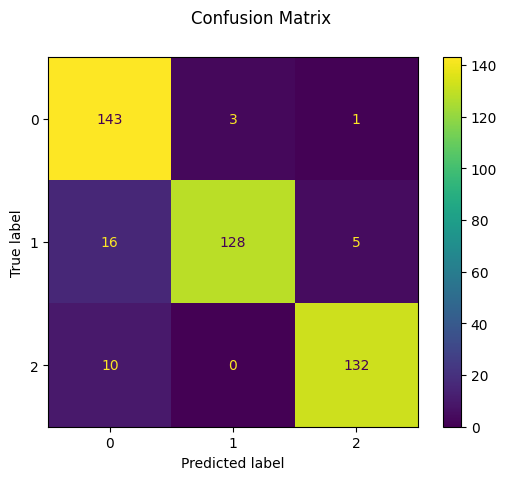

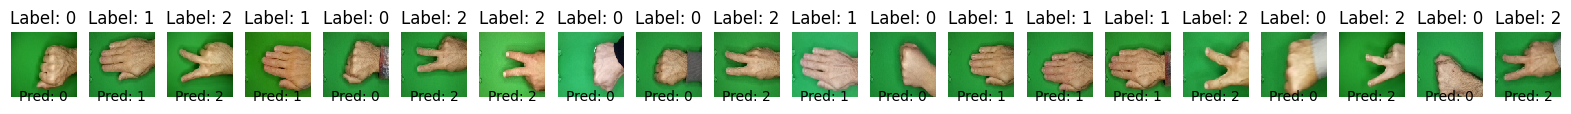

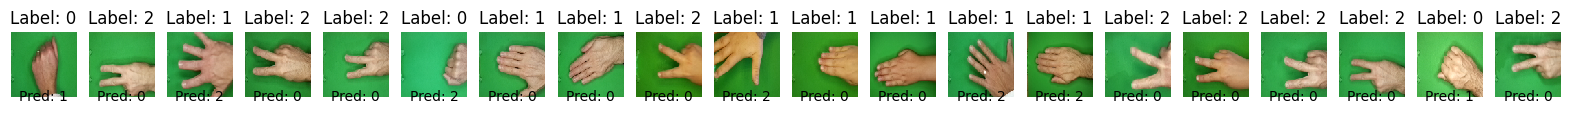

In [ ]:
predicted = clf.predict(instances_hog_test)
performance_evaluation(np.array(labels_test),predicted,"MLP",figsize=(20,8))

#### SVC - Hog

Utilização do SVC para treinamento e validação utilizando Hog. Esse modelo apresentou desempenho mediano com 63% de acurácia

In [ ]:
clf = SVC(max_iter=max_iter,kernel='linear')
clf.fit(instances_hog_train,labels_train)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC(kernel='linear', max_iter=100)

Evaluation of  SVC
              precision    recall  f1-score   support

           0       0.20      0.01      0.01       147
           1       0.45      0.91      0.61       149
           2       0.93      0.88      0.91       142

    accuracy                           0.60       438
   macro avg       0.53      0.60      0.51       438
weighted avg       0.52      0.60      0.50       438


['Pedra', 'Tesoura', 'Papel']


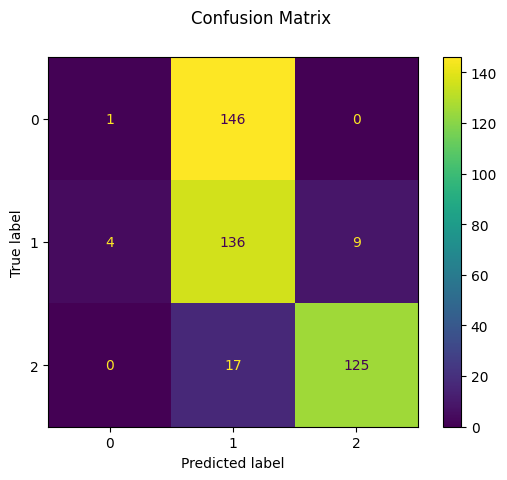

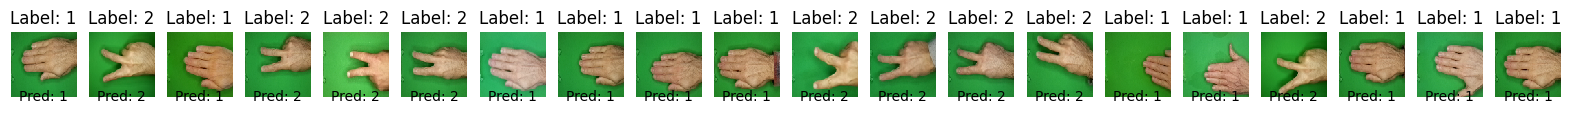

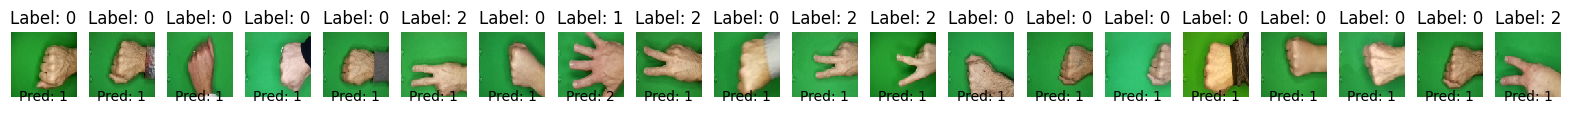

In [ ]:
predicted = clf.predict(instances_hog_test)
performance_evaluation(np.array(labels_test),predicted,"SVC",figsize=(20,8))

#### KNN - Hog

Utilização do KNN para treinamento e validação utilizando Hog. Esse modelo apresentou desempenho mediano com 67% de acurácia

In [ ]:
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(instances_hog_train,labels_train)

KNeighborsClassifier(n_neighbors=3)

Evaluation of  KNN
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       147
           1       1.00      0.52      0.69       149
           2       1.00      0.54      0.70       142

    accuracy                           0.69       438
   macro avg       0.84      0.69      0.69       438
weighted avg       0.84      0.69      0.69       438


['Pedra', 'Tesoura', 'Papel']


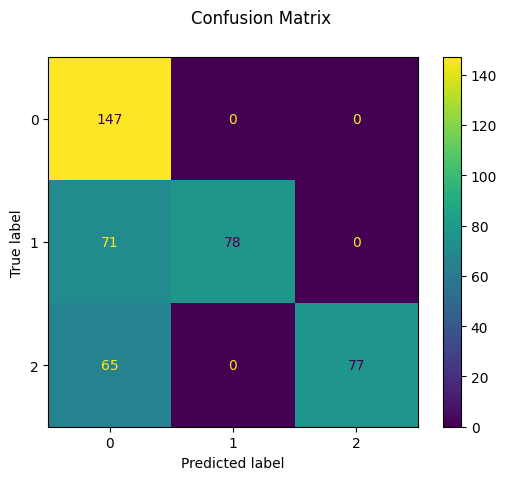

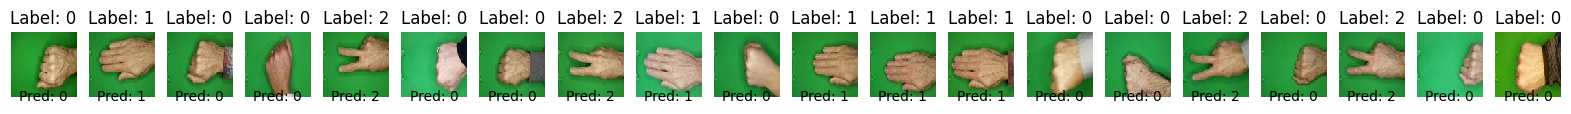

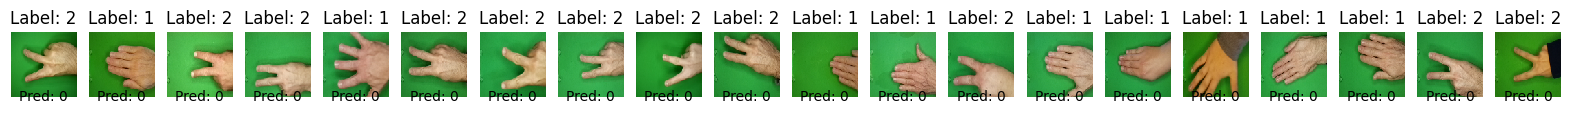

In [ ]:
predicted = clf.predict(instances_hog_test)
performance_evaluation(np.array(labels_test),predicted,"KNN",figsize=(20,8))

#### MLP - hu

Utilização do MLP para treinamento e validação utilizando huMoments. Esse modelo apresentou desempenho mediano com 64% de acurácia

In [ ]:
clf = MLPClassifier(max_iter=500)
clf.fit(instances_hu_train,labels_train)

MLPClassifier(max_iter=500)

[0, 1, 2, 1, 0, 0, 2, 2, 0, 0, 2, 1, 2, 0, 1, 1, 2, 1, 1, 2, 0, 2, 2, 0, 2, 0, 2, 0, 2, 0, 1, 1, 2, 1, 0, 0, 0, 2, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 0, 2, 2, 2, 0, 1, 2, 2, 2, 0, 1, 2, 1, 2, 0, 2, 1, 1, 1, 2, 0, 2, 2, 0, 2, 0, 2, 1, 2, 1, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 2, 1, 2, 1, 2, 1, 2, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 0, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 1, 0, 0, 0, 1, 2, 0, 1, 0, 0, 2, 1, 2, 0, 0, 1, 2, 2, 2, 0, 1, 1, 0, 2, 1, 0, 2, 1, 1, 1, 1, 0, 1, 0, 2, 0, 2, 2, 0, 1, 1, 1, 2, 2, 0, 0, 1, 1, 1, 0, 2, 0, 1, 0, 0, 1, 2, 0, 2, 1, 0, 2, 2, 2, 2, 1, 0, 2, 2, 0, 0, 2, 0, 0, 1, 1, 0, 1, 2, 2, 0, 1, 0, 0, 0, 1, 1, 2, 0, 0, 2, 1, 2, 0, 0, 2, 0, 0, 0, 2, 1, 1, 0, 2, 0, 0, 0, 2, 0, 1, 0, 0, 2, 1, 1, 0, 2, 2, 1, 1, 0, 2, 2, 2, 1, 1, 1, 1, 0, 2, 1, 2, 1, 0, 2, 1, 0, 0, 0, 0, 1, 2, 0, 1, 1, 2, 0, 1, 1, 0, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1, 0, 1, 2, 2, 0, 1, 0, 2, 0, 1, 1, 1, 1, 2, 2, 1, 0, 1, 1, 1, 2, 2, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 2, 2, 0, 0, 2, 

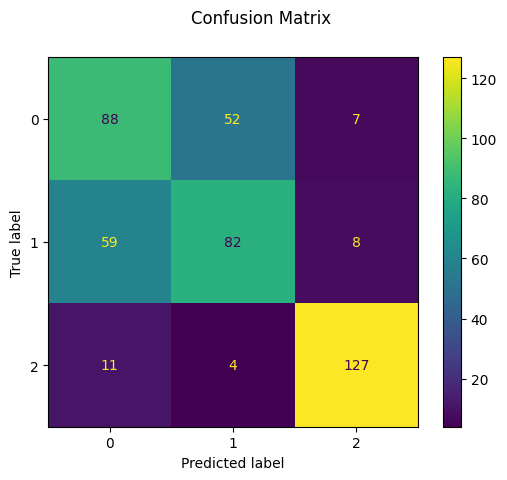

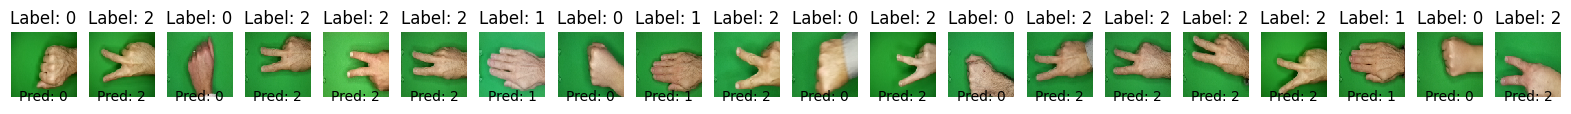

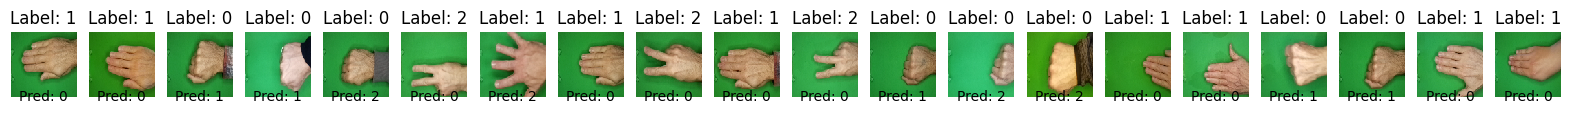

In [ ]:
predicted = clf.predict(instances_hu_test)
print(labels_test,predicted)
performance_evaluation(np.array(labels_test),predicted,"MLP",figsize=(20,8))

#### SVC - hu

Utilização do SVC para treinamento e validação utilizando huMoments. Esse modelo apresentou um desempenho ruim com 37% de acurácia

In [ ]:
clf = SVC(max_iter=max_iter,kernel='linear')
clf.fit(instances_hu_train,labels_train)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC(kernel='linear', max_iter=100)

Evaluation of  SVC
              precision    recall  f1-score   support

           0       0.40      0.66      0.50       147
           1       0.54      0.05      0.09       149
           2       0.49      0.63      0.55       142

    accuracy                           0.44       438
   macro avg       0.48      0.44      0.38       438
weighted avg       0.48      0.44      0.37       438


['Pedra', 'Tesoura', 'Papel']


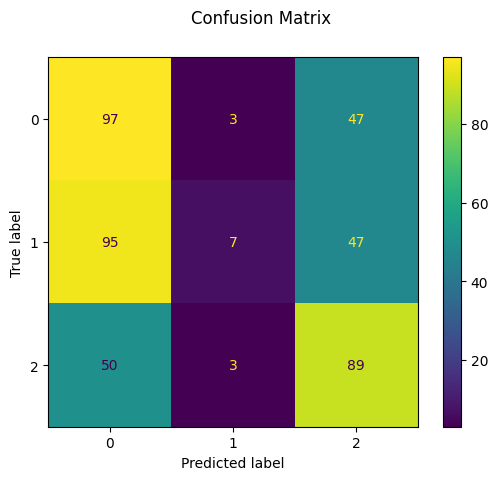

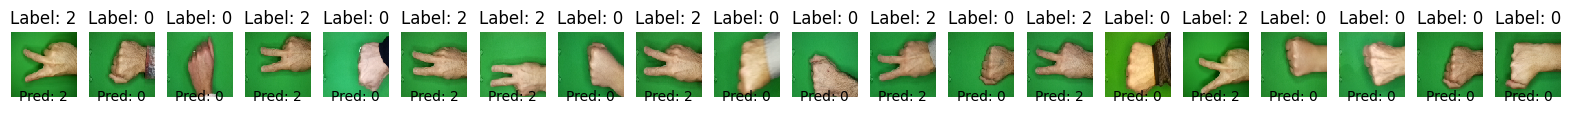

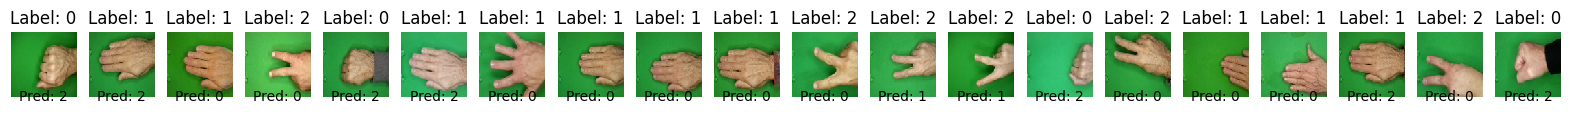

In [ ]:
predicted = clf.predict(instances_hu_test)
performance_evaluation(np.array(labels_test),predicted,"SVC",figsize=(20,8))

#### KNN - hu

Utilização do KNN para treinamento e validação utilizando huMoments. Esse modelo apresentou um desempenho bom com 72% de acurácia. Esse é o segundo melhor modelo

In [ ]:
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(instances_hu_train,labels_train)

KNeighborsClassifier(n_neighbors=3)

Evaluation of  KNN
              precision    recall  f1-score   support

           0       0.69      0.73      0.71       147
           1       0.74      0.70      0.72       149
           2       0.92      0.92      0.92       142

    accuracy                           0.78       438
   macro avg       0.78      0.78      0.78       438
weighted avg       0.78      0.78      0.78       438


['Pedra', 'Tesoura', 'Papel']


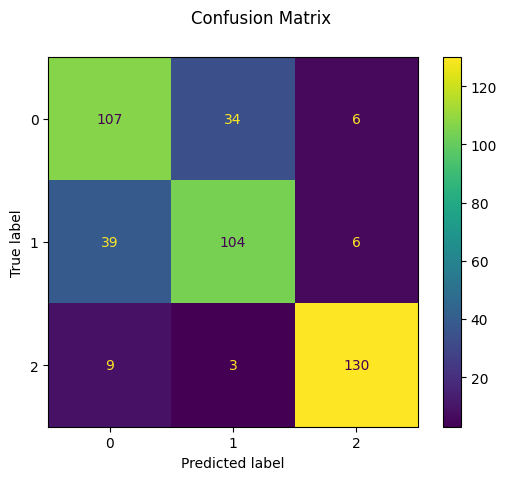

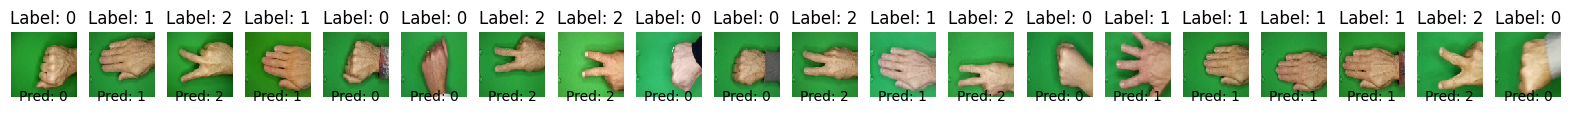

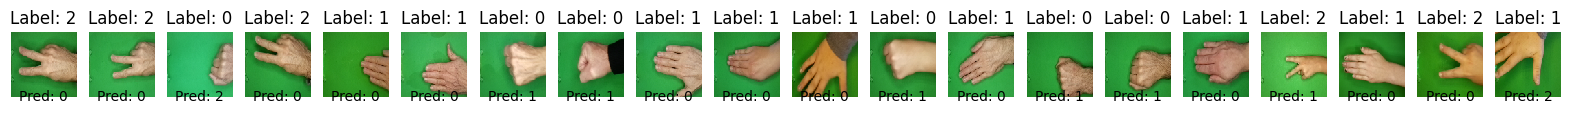

In [ ]:
predicted = clf.predict(instances_hu_test)
performance_evaluation(np.array(labels_test),predicted,"KNN",figsize=(20,8))

#### MLP - Gabor

Utilização do MPL para treinamento e validação utilizando Gabor. Esse modelo apresentou um desempenho ruim com 34% de acurácia

In [ ]:
clf = MLPClassifier(max_iter=500)
clf.fit(instances_gabor_train,labels_train)

MLPClassifier(max_iter=500)

Evaluation of  MLP
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       147
           1       0.34      1.00      0.51       149
           2       0.00      0.00      0.00       142

    accuracy                           0.34       438
   macro avg       0.11      0.33      0.17       438
weighted avg       0.12      0.34      0.17       438


['Pedra', 'Tesoura', 'Papel']


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


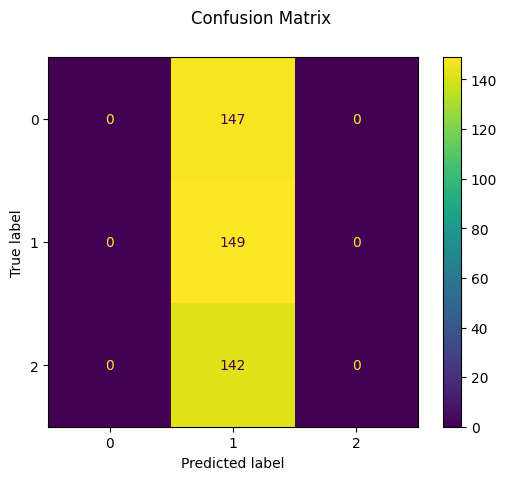

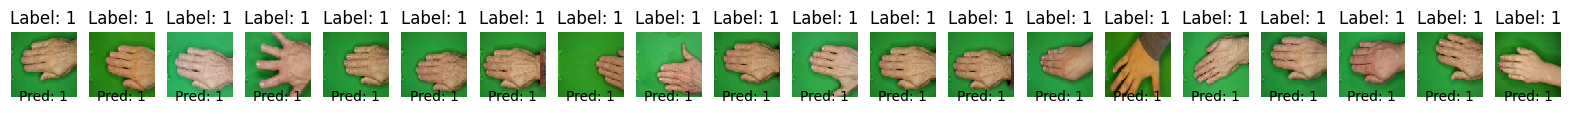

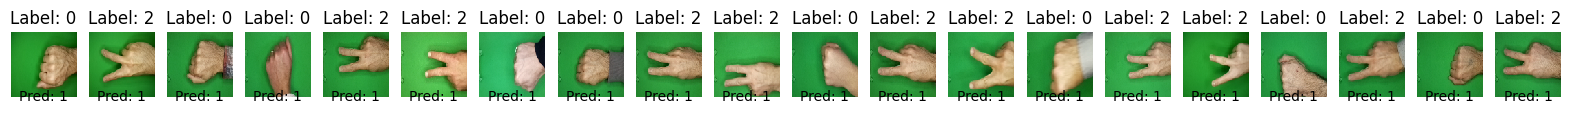

In [ ]:
predicted = clf.predict(instances_gabor_test)
performance_evaluation(np.array(labels_test),predicted,"MLP",figsize=(20,8))

#### SVC - Gabor

Utilização do SVC para treinamento e validação utilizando Gabor. Esse modelo apresentou um desempenho ruim com 32% de acurácia

In [ ]:
clf = SVC(max_iter=max_iter,kernel='linear')
clf.fit(instances_gabor_train,labels_train)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC(kernel='linear', max_iter=100)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation of  SVC
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       147
           1       0.00      0.00      0.00       149
           2       0.32      1.00      0.49       142

    accuracy                           0.32       438
   macro avg       0.11      0.33      0.16       438
weighted avg       0.11      0.32      0.16       438


['Pedra', 'Tesoura', 'Papel']


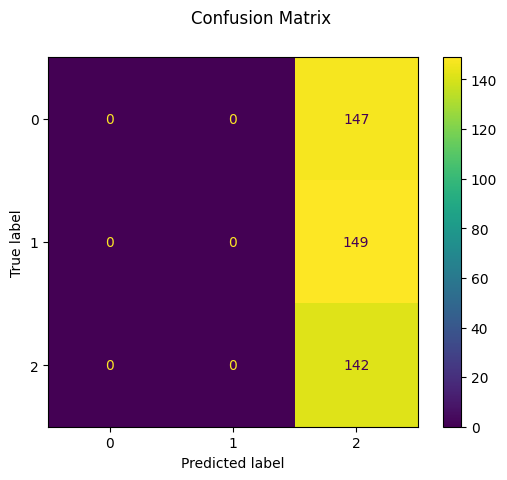

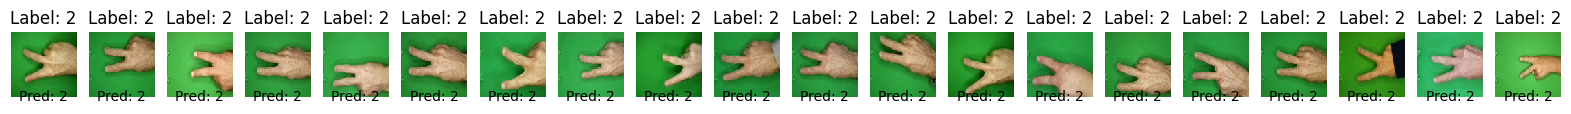

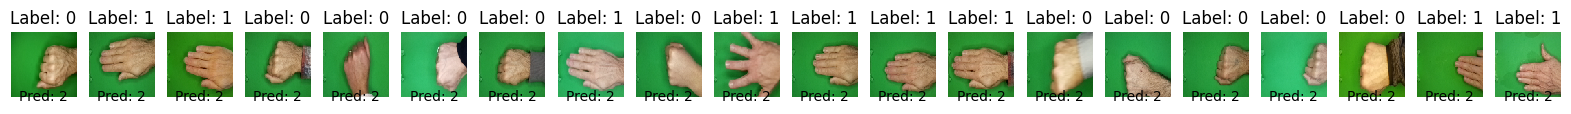

In [ ]:
predicted = clf.predict(instances_gabor_test)
performance_evaluation(np.array(labels_test),predicted,"SVC",figsize=(20,8))

#### KNN - Gabor

Utilização do KNN para treinamento e validação utilizando huMoments. Esse modelo apresentou um desempenho ruim com 34% de acurácia

In [ ]:
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(instances_gabor_train,labels_train)

KNeighborsClassifier(n_neighbors=3)

Evaluation of  KNN
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       147
           1       0.34      1.00      0.51       149
           2       0.00      0.00      0.00       142

    accuracy                           0.34       438
   macro avg       0.11      0.33      0.17       438
weighted avg       0.12      0.34      0.17       438


['Pedra', 'Tesoura', 'Papel']


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


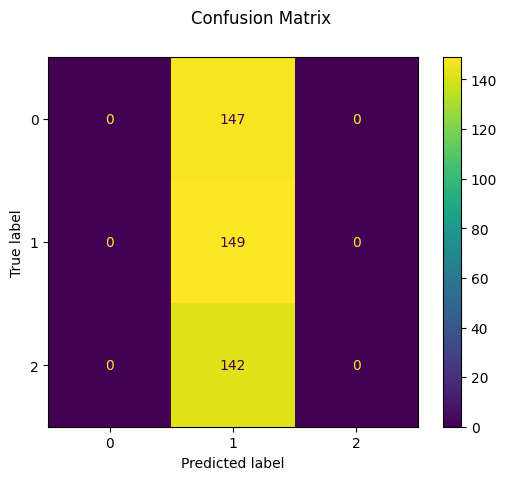

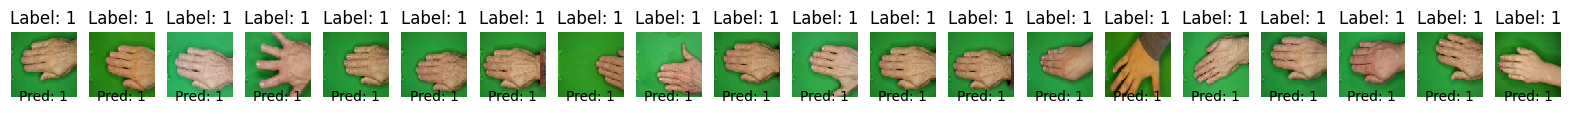

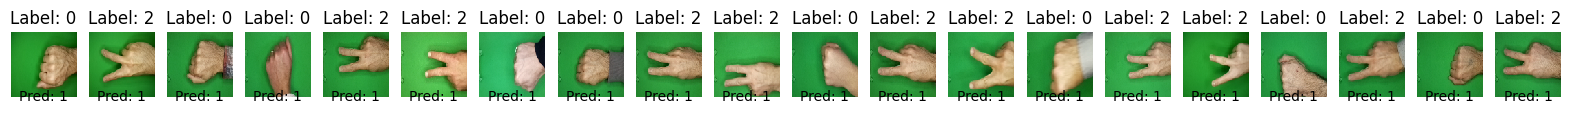

In [ ]:
predicted = clf.predict(instances_gabor_test)
performance_evaluation(np.array(labels_test),predicted,"KNN",figsize=(20,8))

### **Final Remarks (Classification Step)**:

Discuss in-depth the results achieve in this step.

Is there any bottleneck?
What technique worked better? or what did not work?
What motivated you to implement that approach?
Discuss and present some results.

Nos métodos de classificação utilizado, percebemos clara vantagem em utilizar o Hog com MLP. Acreditamos que Hog apresentou a melhor representação do contorno (o hog também apresenta o maior vetor de features) e com isso a rede neural MLP conseguiu encontrar os padrões do contorno das mãos em relação aos Labels. Em relação as limitações, percebemos que o método Gabor não apresentou features distintas o suficiente, constatamos que os 3 classificadores utilizados não conseguiram aprender com os exemplos proporcionados

#**Final Conclusions / Discussions:**

Provide a brief discussion of your pipeline (Segmentation + Classification), I mean, in natural language, discuss the approach, which techniques you applied, and the sequence.

Also, you should use this space to better discuss the results, and bottleneck and clarify the decisions, etc etc.



Na segmentação, obtivemos sucesso ao converter a imagem para HSV e usar o histograma do hue para determinar o limite apropriado de binarização das imagens. Isso resultou em bounding boxes mais precisas ao redor da mão. Inicialmente testamos o HOG aumentando a resolução da imagem para 256x256, observamos uma melhora na precisão e detalhamento do contorno. Outros descritores de imagem, como o Gabor e o Hu, não performaram tão bem quanto o HOG, especialmente em relação à precisão nos contornos. Acreditamos que o desempenho inferior do Gabor se deve ao fato de que a textura da mão não é um fator decisivo para a classificação. Por fim, nosso melhor resultado foi atingido com Hog e MLP
